# Starbucks Capstone Challenge

## 1. Project Defination

### Project Overview

   Starbucks mobile users use mobile app to order, pay and to track the rewards they received.
   
   This project uses the data that mimics customer behavior on the starbuck rewards mobile app.
   Starbucks sends out different types of offers such as BOGO(Buy One Get One), Discount or just an advertisement to users. Not all users receive the same offer. Also some users moght not receive any offer during certain weeks.
   
   Here i am going to use demographic, offers and transaction data to find out some interesting patterns and also to do some predictions by using ML.
   

### Problem Statement

   Our goal is to use the data for analysis and modeling to address following issues
   - What is the income range where the most of the customers falls? Whats is minimum and maximum income of Starbucks Customers?
   - Which age group and gender uses the Starbucks app the most?
   - What types of offers are mostly offered by the Starbucks?
   - What Type of offer the customers attracted towards (i.e. customers completes these offers)?
   - Prediction of if the customer will complete or offer or not.
   
### Metrics

   Most of the above issues can be addressed by EDA using visualizations.
   
   For modeling and prediction we are going to use classification accuracy and Classification matric because this is a binary classification problem


## 2. Analysis
  
### Data Sets



The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record



In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [3]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [4]:
profile.shape

(17000, 5)

In [5]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [6]:
transcript.shape

(306534, 4)

## 2. Analysis
  
### Data Exploration And Visualisation



Here we are going to analyse above data file, also we will combine the data when needed


#### Customer Data Distribition

Lets get overall statistics of the data


In [7]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


To address our first issue we will see income disribution

<AxesSubplot:>

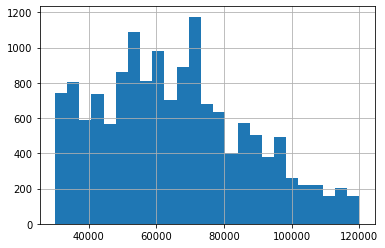

In [8]:
profile.income.hist(bins=25)

**Customer's income is between 30000 to 120000, and most customers are having income between 50k to 80k**

- Gender wise customer disribution

<AxesSubplot:>

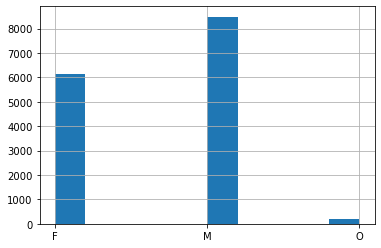

In [9]:
profile.gender.hist()

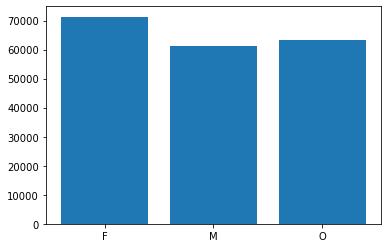

In [10]:

plt.bar(profile.groupby('gender').mean().index.tolist(),profile.groupby('gender')['income'].mean())

plt.show()

**Female customers has more avg income than male and other
Also Most of the customers are male customers followed by female and then others**

- Age wise customer distribution

<AxesSubplot:>

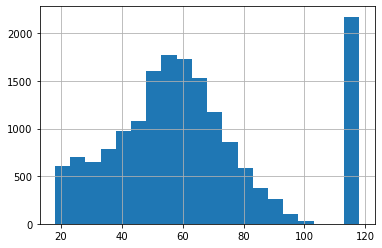

In [11]:
profile.age.hist(bins=20)

mostly the users are between 45 to 70 of age. The bar at the right side are mostly (age=118) the customers whose age is not known
we have to check other details for customers of age=118

In [12]:
# how many customers are there with no age data
profile[profile['age']==118].groupby('age')['id'].count()

age
118    2175
Name: id, dtype: int64

In [13]:
# % of customers are there with no age data
profile[profile['age']==118].groupby('age')['id'].count()*100/profile.shape[0]

age
118    12.794118
Name: id, dtype: float64

12% of customers dont have age data

Now checking for the income and age details for such customers

In [14]:
profile[profile['age']==118].groupby('age')['income'].count()

age
118    0
Name: income, dtype: int64

In [15]:
profile[profile['age']==118].groupby('age')['gender'].count()

age
118    0
Name: gender, dtype: int64

**There are 2175 customers which do not have demografix infortation like income,age,gendee etc. which is 12% of total count**

Also we can convert bocome_member_on field from date to age_on_network (in days) which will indicate from how much time customer is member of statbucks. below function does the same. 

In addition to this, we are mapping id values which are of hash type to small int number.

In [16]:
# create mapping for customer_id hash and id
customer_id_dict = profile['id'].to_dict()
customer_id_dict = {value:key for key, value in customer_id_dict.items()}


In [17]:
def clean_data(df):
    
    # derive column age_on_network from became_member_on
    df['became_member_on'] = pd.to_datetime(df['became_member_on'], format='%Y%m%d')
    
    max_date = df['became_member_on'].max()
    df['age_on_network'] = (max_date - df['became_member_on']) / np.timedelta64(1,'D')
    

    # change id from hash to int id
    df['id'] = df['id'].map(customer_id_dict)

    return df

In [18]:
profile_new = clean_data(profile)
profile_new = profile_new.rename(columns={'id':'customer_id'})
profile_new.head()

,gender,age,customer_id,became_member_on,income,age_on_network
0,None,118,0,2017-02-12,NaN,529.0
1,F,55,1,2017-07-15,112000.0,376.0
2,None,118,2,2018-07-12,NaN,14.0
3,F,75,3,2017-05-09,100000.0,443.0
4,None,118,4,2017-08-04,NaN,356.0


- Customer's age on netwok Data Distribition

<AxesSubplot:>

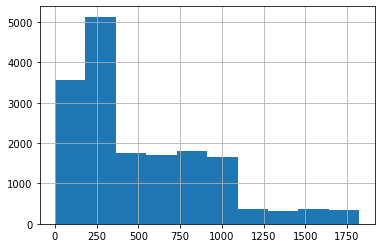

In [19]:
profile_new.age_on_network.hist()


Most of the customer became members of the Starbucks in last 2 years when the data was captured 

In [20]:
profile_new.head()

,gender,age,customer_id,became_member_on,income,age_on_network
0,None,118,0,2017-02-12,NaN,529.0
1,F,55,1,2017-07-15,112000.0,376.0
2,None,118,2,2018-07-12,NaN,14.0
3,F,75,3,2017-05-09,100000.0,443.0
4,None,118,4,2017-08-04,NaN,356.0


#### Offers/transactions Data Distribition


The value column is in dictionary format, we will extract this 

In [21]:

transcript_new = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)


In [22]:
transcript_new['oid'] = np.where(transcript_new['offer id'].isnull() & transcript_new['offer_id'].notnull(), transcript_new['offer_id'],transcript_new['offer id'])




In [23]:
transcript_new.drop(['offer id', 'offer_id'], axis=1, inplace=True)

# rename the offer_id column
transcript_new.rename(columns={'oid': 'offer_id'}, inplace=True)

In [24]:
transcript_new.head()

,person,event,value,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


Map the person column which is hash type to id, we have already created mapping dict for this above.

Similarly we can conver offer_id hash value to redable id 

In [25]:
transcript_new['person'] = transcript_new['person'].map(customer_id_dict)

transcript_new = transcript_new.rename(columns={'person':'customer_id'})

In [26]:
transcript_new.offer_id.nunique()

10

In [27]:
# create mapping for offer_id hash and id
offer_id_dict = pd.Series(transcript_new['offer_id'].unique()).to_dict()
offer_id_dict = {value:key for key, value in offer_id_dict.items()}


In [28]:
offer_id_dict

{'9b98b8c7a33c4b65b9aebfe6a799e6d9': 0,
 '0b1e1539f2cc45b7b9fa7c272da2e1d7': 1,
 '2906b810c7d4411798c6938adc9daaa5': 2,
 'fafdcd668e3743c1bb461111dcafc2a4': 3,
 '4d5c57ea9a6940dd891ad53e9dbe8da0': 4,
 'f19421c1d4aa40978ebb69ca19b0e20d': 5,
 '2298d6c36e964ae4a3e7e9706d1fb8c2': 6,
 '3f207df678b143eea3cee63160fa8bed': 7,
 'ae264e3637204a6fb9bb56bc8210ddfd': 8,
 '5a8bc65990b245e5a138643cd4eb9837': 9,
 nan: 10}

In [29]:
transcript_new['offer_id'] = transcript_new['offer_id'].map(offer_id_dict)

In [30]:
transcript_new.head()

,customer_id,event,value,time,amount,reward,offer_id
0,3,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,0
1,4,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,1
2,5,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2
3,6,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,NaN,3
4,7,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4


#### Portfolio Data Distribition

In [31]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [32]:
portfolio.describe()

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


**Maximum Amount to spend for any offer is 20 and maximum duration of offer is 10**

In [33]:
# map offer id in hah format to readble id
portfolio_new = portfolio.copy()
portfolio_new['id'] = portfolio_new['id'].map(offer_id_dict)

portfolio_new = portfolio_new.rename(columns={'id':'offer_id'})

In [34]:
portfolio_new.head()

,reward,channels,difficulty,duration,offer_type,offer_id
0,10,"[email, mobile, social]",10,7,bogo,8
1,10,"[web, email, mobile, social]",10,5,bogo,4
2,0,"[web, email, mobile]",0,4,informational,7
3,5,"[web, email, mobile]",5,7,bogo,0
4,5,"[web, email]",20,10,discount,1


Let's see how many offers are there for each offer type

In [35]:
portfolio_new.groupby('offer_type')['offer_id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: offer_id, dtype: int64

**Out of 10 offer 4 BOGO, 4 Discount and 2 informational offers are there**

### All Data Combined Analysis
Let's combine  transcript and portfolio data in a single dataframe

In [36]:
# merge offer's data with offer transaction data
df = pd.merge(transcript_new, portfolio_new, on='offer_id', how='left')
df.head()

,customer_id,event,value,time,amount,reward_x,offer_id,reward_y,channels,difficulty,duration,offer_type
0,3,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,NaN,NaN,0,5.0,"[web, email, mobile]",5.0,7.0,bogo
1,4,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,NaN,NaN,1,5.0,"[web, email]",20.0,10.0,discount
2,5,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,NaN,NaN,2,2.0,"[web, email, mobile]",10.0,7.0,discount
3,6,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,NaN,NaN,3,2.0,"[web, email, mobile, social]",10.0,10.0,discount
4,7,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,NaN,NaN,4,10.0,"[web, email, mobile, social]",10.0,5.0,bogo


In [37]:
df.shape

(306534, 12)

In [38]:
# merge offer's data with customer's profile data
df_all = pd.merge(df, profile_new, on='customer_id', how='left')

df_all.drop(['value', 'became_member_on' ], axis=1,inplace=True)

In [39]:
df_all.shape

(306534, 15)

In [40]:
df_all.head()

,customer_id,event,time,amount,reward_x,offer_id,reward_y,channels,difficulty,duration,offer_type,gender,age,income,age_on_network
0,3,offer received,0,NaN,NaN,0,5.0,"[web, email, mobile]",5.0,7.0,bogo,F,75,100000.0,443.0
1,4,offer received,0,NaN,NaN,1,5.0,"[web, email]",20.0,10.0,discount,None,118,NaN,356.0
2,5,offer received,0,NaN,NaN,2,2.0,"[web, email, mobile]",10.0,7.0,discount,M,68,70000.0,91.0
3,6,offer received,0,NaN,NaN,3,2.0,"[web, email, mobile, social]",10.0,10.0,discount,None,118,NaN,304.0
4,7,offer received,0,NaN,NaN,4,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,None,118,NaN,297.0


Below we are checking offer type wise customer's distribution which will contain all events on offer (received, viewd and completed)

In [41]:
df_all.groupby('offer_type')['event'].count()

offer_type
bogo             71617
discount         69898
informational    26066
Name: event, dtype: int64

<AxesSubplot:ylabel='customer_id'>

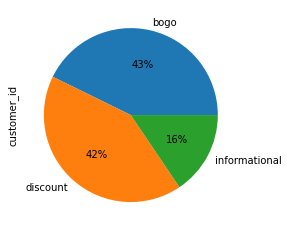

In [42]:

df_all.groupby(['offer_type'])['customer_id'].count().plot.pie(autopct='%1.0f%%')


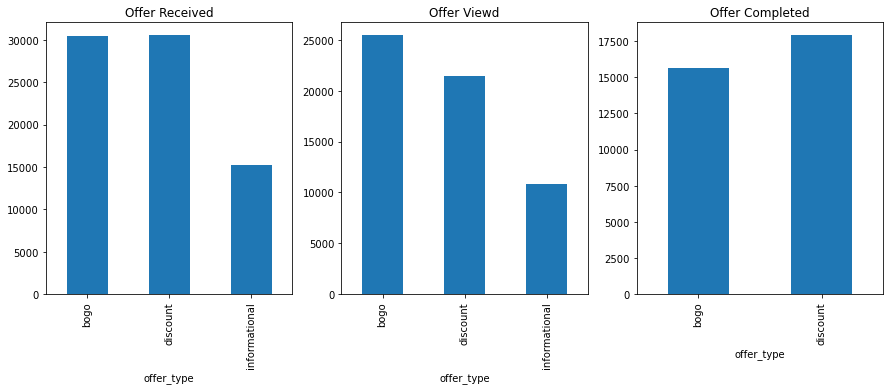

In [43]:
plt.subplot(131)
df_all[df_all['event']=='offer received'].groupby(['offer_type'])['customer_id'].count().plot.bar(title="Offer Received",figsize=(15,5))
plt.subplot(132)
df_all[df_all['event']=='offer viewed'].groupby(['offer_type'])['customer_id'].count().plot.bar(title="Offer Viewd")
plt.subplot(133)
df_all[df_all['event']=='offer completed'].groupby(['offer_type'])['customer_id'].count().plot.bar(title="Offer Completed")
plt.show()

From above pie and bar charts it is evident that,
- Nearly 85 % offer related hits are of type BOGO and Discount combined whereas informational offers are very less 
- Even of BOGO and Discount are approximately equally send to customers, BOGO offers are mostly viewed by customers compared to discounts. But Discount offers are more completed than the BOGO.


In [44]:
df_all.head()

,customer_id,event,time,amount,reward_x,offer_id,reward_y,channels,difficulty,duration,offer_type,gender,age,income,age_on_network
0,3,offer received,0,NaN,NaN,0,5.0,"[web, email, mobile]",5.0,7.0,bogo,F,75,100000.0,443.0
1,4,offer received,0,NaN,NaN,1,5.0,"[web, email]",20.0,10.0,discount,None,118,NaN,356.0
2,5,offer received,0,NaN,NaN,2,2.0,"[web, email, mobile]",10.0,7.0,discount,M,68,70000.0,91.0
3,6,offer received,0,NaN,NaN,3,2.0,"[web, email, mobile, social]",10.0,10.0,discount,None,118,NaN,304.0
4,7,offer received,0,NaN,NaN,4,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,None,118,NaN,297.0


## 3. Methodology
  
### Data Preprocessing


Some part of data preprocessinf we already did in data analysis and exploration part which is 
- mapping hash type offer and customer ids to readable ids
- extracting data from columns of type dictionary 
- Handling NaN values
- Combining the data from separate dataframes to single dataframe

Below we will do additional preprocessing, required for the data modeling
- dummying the categorical features
- handle NaN values like age =118
- drop columns not required for classification

For our prediction, our target variable for classification is offer_completed. We cannot apply model directly to this data. Because for same offer-customer combination, we can have multiple rows, one for each offer related event.

For example, we can have three records for same customer and offer id - one for offer received, one record for offer viewed and one for offer completed (we are not considering transaction data here).

For this we have get data at offer_id-customer_id level.

In [45]:
df_model = df_all.copy()

In [46]:

def get_dummy(df,col,to_drop =False):
    '''
    function to dummy categorical variables
    Input: 
        df - dataframe to process
        col - Name of the column to dully 
        to_drop - true if we want to drop first dummied column
    Output:
        df - dataframe will added dummy columns deleting original column 'col'
    '''
    df=pd.concat([df[:],pd.get_dummies(df[col],prefix=col,drop_first=to_drop)],axis=1)
    df=df.drop(columns=col,axis=1,inplace=False)
    return df

In [47]:
# remove unwanted rows and columns 
df_model = df_model[df_model['age']!=118]
df_model = df_model[df_model['event']!='transaction']
df_model = get_dummy(df_model,'event')
df_model = get_dummy(df_model,'offer_type',True)
df_model = get_dummy(df_model,'gender',True)
df_model.drop(['amount', 'reward_x','channels',], axis=1, inplace=True)
df_model.head()

,customer_id,time,offer_id,reward_y,difficulty,duration,age,income,age_on_network,event_offer completed,event_offer received,event_offer viewed,offer_type_discount,offer_type_informational,gender_M,gender_O
0,3,0,0,5.0,5.0,7.0,75,100000.0,443.0,0,1,0,0,0,0,0
2,5,0,2,2.0,10.0,7.0,68,70000.0,91.0,0,1,0,1,0,1,0
5,8,0,5,5.0,5.0,5.0,65,53000.0,167.0,0,1,0,0,0,1,0
7,12,0,7,0.0,0.0,4.0,58,51000.0,257.0,0,1,0,0,1,1,0
8,13,0,1,5.0,20.0,10.0,61,57000.0,318.0,0,1,0,1,0,0,0


In [48]:
df_model.columns

Index(['customer_id', 'time', 'offer_id', 'reward_y', 'difficulty', 'duration',
       'age', 'income', 'age_on_network', 'event_offer completed',
       'event_offer received', 'event_offer viewed', 'offer_type_discount',
       'offer_type_informational', 'gender_M', 'gender_O'],
      dtype='object')

Group data at customer_id,Offer_id level so that we can have single record for each customer and offer with all offer events in seperate columns ( offer received, offer viewd, offer completed )

In [49]:
df_new = df_model.groupby(['customer_id', 'offer_id']).max()
# df_new.head()
df_new = df_new.reset_index()



### Implementation 

We are using Decision tree classifier for this classification

In [50]:
# Seperate features an target variables

X = df_new.drop(['event_offer completed','customer_id','offer_id',],axis=1)
Y = df_new['event_offer completed']

In [51]:
# take train 70 % and test 30 % data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2023)

# fit the decision tree classifier

clf = DecisionTreeClassifier(random_state=2023)
clf.fit( X_train , y_train )

    


DecisionTreeClassifier(random_state=2023)

In [52]:
# predict the data and print accuracy 
y_pred = clf.predict(X_test)
    
print("\nClassification Report: ")
print(classification_report(y_test, y_pred))
print("\nAccuracy: ")
acc = accuracy_score(y_test, y_pred)
print(acc)





Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.79      0.79      8176
           1       0.79      0.79      0.79      8391

    accuracy                           0.79     16567
   macro avg       0.79      0.79      0.79     16567
weighted avg       0.79      0.79      0.79     16567


Accuracy: 
0.7885555622623287


We are getting 79% accuracy for DT classifier without any tuning and parameter selection
We can refine this model as shown in below section


### Refinement 

We can refine this model using GridsearchCV which tries different paramets and gives us the best parameter to use

We have chosen parameters for DT as different depth, split and leaf ranges

In [53]:


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2023)

# select and define parameters

depth_range = [3,4,5,6,7,8,9]
minsplit_range = [5,10,20,25,30]
minleaf_range = [5,10,15]
parameters = dict(max_depth=depth_range,
                  min_samples_split=minsplit_range, 
                  min_samples_leaf=minleaf_range)
    


In [54]:
# fit the model using GridSearchCV
clf = DecisionTreeClassifier(random_state=2023)
cv = GridSearchCV(clf, param_grid=parameters,cv=5)
    
cv.fit( X_train , y_train )



GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=2023),
             param_grid={'max_depth': [3, 4, 5, 6, 7, 8, 9],
                         'min_samples_leaf': [5, 10, 15],
                         'min_samples_split': [5, 10, 20, 25, 30]})

In [55]:
# best parametes and score 
print("Best Parameters")
print(cv.best_params_)
print("\nBest Score")
print(cv.best_score_)
print("\nBest Estimator")
print(cv.best_estimator_)


Best Parameters
{'max_depth': 9, 'min_samples_leaf': 10, 'min_samples_split': 5}

Best Score
0.814306040615703

Best Estimator
DecisionTreeClassifier(max_depth=9, min_samples_leaf=10, min_samples_split=5,
                       random_state=2023)


In [56]:
# choose the best model found and fit the same
best_model = cv.best_estimator_
    
dt = best_model

dt.fit( X_train , y_train )
    
# predict on test data
y_pred = dt.predict(X_test)



In [57]:
# print the results
print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report: ")
print(classification_report(y_test, y_pred))
print("\nAccuracy: ")
acc = accuracy_score(y_test, y_pred)
print(acc)


Confusion Matrix: 
[[6165 2011]
 [1048 7343]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.75      0.80      8176
           1       0.79      0.88      0.83      8391

    accuracy                           0.82     16567
   macro avg       0.82      0.81      0.81     16567
weighted avg       0.82      0.82      0.81     16567


Accuracy: 
0.8153558278505463


**We got 81% of accuracy after tuning which is good**

## 3. Results
  
### Model Evaluation and validation



The classfication model we have used here is giving 81% overall accuracy for detection customer will complete an offer or not. for this f1 score is also very good which combine precision and recall.
Also we used consfision matrix to get more insights of the result like positives and false pasitives 


In [58]:
# print the results
print("\nConfusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report: ")
print(classification_report(y_test, y_pred))
print("\nAccuracy: ")
acc = accuracy_score(y_test, y_pred)
print(acc)


Confusion Matrix: 
[[6165 2011]
 [1048 7343]]

Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.75      0.80      8176
           1       0.79      0.88      0.83      8391

    accuracy                           0.82     16567
   macro avg       0.82      0.81      0.81     16567
weighted avg       0.82      0.82      0.81     16567


Accuracy: 
0.8153558278505463


## 3. Conclusion
  
### Reflection

We have done the analysis and modeling to address issues mentioned in the problem statement. Through this process we found below observations
   - The income data is normally distributed with income is between 30k to 120k with mean 65k
   - Middle age customers are more to use this app, so we can say that mostly working people are using this app
   - The customers are increasing over the years and more than 60% of the customers are signed up in last two years of the data
   - Starbucks is offering approximately same BOGO and Discount offer types
   - Even of BOGO and Discount are aprroximatly equally send to customers, BOGO offers are mostly viewed by customers compared to discounts. But Discount offers are more completed than the BOGO.

We also build a model to predict whether a customer will complete the offer or not with good accuracy
   
### Improvement 

- We can improve the model accuracy by using other better algorithms like random forest, Also we can use boosting approach to get the better accuracy 
- We can deploy this model on web and we can see how it works for new customers
- We can use recommendation engine to get recommendations for which offers is suitable to a customer 
